# Effect of instantaneous weather sampling rate on subhourly clipping errors - SURFRAD
These notebooks resample the SURFRAD network data at different frequencies to simulate satellite data.

In [1]:
import calendar
import pathlib
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pvlib
import rdtools
import seaborn as sns

sns.set(font_scale=1.5, rc={'figure.figsize': (16, 10)})

DAYMINUTES = 24*60
KELVINS = 273.15
MAX_GHI_RATIO = 1.5

In [2]:
def read_surfrad_year(surfrad_year_path):
    data = [pvlib.iotools.read_surfrad(f) for f in surfrad_year_path.iterdir()]
    dfs, heads = zip(*data)
    df = pd.concat(dfs)
    header = heads[0]
    return df, header

In [18]:
def estimate_air_temp(year_start, surfrad, lat, lon, cs, max_ghi_ratio=MAX_GHI_RATIO):
    """
    Use clear sky temps scaled by daily ratio of measured to clear sky global
    insolation.

    Parameters
    ----------
    year_start : str
        SURFRAD data year
    surfrad : pandas.DateFrame
        surfrad data frame
    lat : float
        latitude in degrees north of equator [deg]
    lon : float
        longitude in degrees east of prime meridian [deg]
    cs : pandas.DataFrame
        clear sky irradiances [W/m^2]
    max_ghi_ratio : float
        daily GHI to clear sky GHI ratio is clipped at this limit

    Returns
    -------
    est_air_temp : pandas.DataFrame
        estimated air temperature in Celsius [C]
    temp_adj : pandas.Series
        temperature adjustment [C}
    ghi_ratio : pandas.Series
        ratio of  daily SURFRAD to clearsky GHI insolation
    daily_delta_temp : numpy.array
        daily temperature range, max - min, in Kelvin [K]
    cs_temp_air : pandas.Series
        clear sky air temperatures in Celsius [C]

    """
    daze = 367 if calendar.isleap(int(year_start)) else 366
    # create a leap year of minutes for the given year at UTC
    year_minutes = pd.date_range(
        start=year_start, freq='T', periods=daze*DAYMINUTES, tz='UTC')
    # clear sky temperature
    cs_temp_air = rdtools.clearsky_temperature.get_clearsky_tamb(
        year_minutes, lat, lon)
    # organize by day
    cs_temp_daily = cs_temp_air.values.reshape((daze, DAYMINUTES)) + KELVINS
    # get daily temperature range
    daily_delta_temp = np.array([td.max()-td.min() for td in cs_temp_daily])
    daily_delta_temp = pd.Series(
        daily_delta_temp, index=cs_temp_air.resample('D').mean().index)
    # calculate ratio of daily insolation versus clearsky
    ghi_ratio = surfrad.ghi.resample('D').sum() / cs.ghi.resample('D').sum()
    # limit ghi ratio and remove +/-inf
    ghi_ratio = np.clip(ghi_ratio, 0, max_ghi_ratio)
    ghi_ratio = ghi_ratio.rename('ghi_ratio')
    # apply ghi ratio to next day, wrap days to start at day 1
    day1 = ghi_ratio.index[0]
    ghi_ratio.index = ghi_ratio.index + pd.tseries.frequencies.to_offset('1D')
    # set day 1 estimated air temp equal to last day
    ghi_ratio[day1] = ghi_ratio.iloc[-1]
    # fix day 1 is added last, so out of order
    ghi_ratio = ghi_ratio.sort_index()
    # scale daily temperature delta by the ratio of insolation from day before
    temp_adj = (ghi_ratio - 1.0)*daily_delta_temp[ghi_ratio.index]  # use next day
    # where GHI ratio is not finite, use unadjusted clear sky temp
    temp_adj = temp_adj.where(ghi_ratio>0, 0)
    temp_adj = temp_adj.rename('temp_adj')
    # interpolate smoothly, but fill forward minutes in last day
    est_air_temp = pd.concat(
        [cs_temp_air,
         ghi_ratio.resample('1min').interpolate(),
         temp_adj.resample('1min').interpolate()], axis=1).pad()
    # Tadj = Tcs + (GHI/CS_GHI - 1) * DeltaT 
    # if GHI/CS_GHI > 1 then adjustment > DeltaT
    est_air_temp['Adjusted Temp (C)'] = (
        est_air_temp['Clear Sky Temperature (C)'] + est_air_temp.temp_adj)
    return est_air_temp, temp_adj, ghi_ratio, daily_delta_temp, cs_temp_air

In [4]:
# get glob of weather files
surfrad_dir = pathlib.Path('../../SURFRAD')
print(f'Is there really a \33[1m\33[91m"SURFRAD"\33[0m\33[0m directory?'
      f' \33[1m\33[92m{surfrad_dir.exists()} \u2713\33[0m\33[0m')

Is there really a "SURFRAD" directory? True ✓


In [5]:
# get glob of Bondville, IL, yearly files
weather_dir = "Bondville_IL"
weather_path = surfrad_dir / weather_dir
print(f'Is there really a \33[1m\33[91m"{weather_path}"\33[0m\33[0m directory?'
      f' \33[1m\33[92m{weather_path.exists()} \u2713\33[0m\33[0m')

Is there really a "..\..\SURFRAD\Bondville_IL" directory? True ✓


In [6]:
# get a glob of years
weather_years = weather_path.iterdir()
years = [p.parts[-1] for p in weather_years]
years

['1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021']

In [7]:
#for year in weather_path.iterdir():
weather_years = list(weather_path.iterdir())
df, header = read_surfrad_year(weather_years[0])
df.head()

,year,jday,month,day,hour,minute,dt,solar_zenith,ghi,ghi_flag,...,temp_air,temp_air_flag,relative_humidity,relative_humidity_flag,wind_speed,wind_speed_flag,wind_direction,wind_direction_flag,pressure,pressure_flag
1995-01-01 00:00:00+00:00,1995,1,1,1,0,0,0.00,104.93,-5.9,0,...,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1
1995-01-01 00:03:00+00:00,1995,1,1,1,0,3,0.05,105.48,-6.1,0,...,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1
1995-01-01 00:06:00+00:00,1995,1,1,1,0,6,0.10,106.03,-6.1,0,...,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1
1995-01-01 00:09:00+00:00,1995,1,1,1,0,9,0.15,106.58,-6.0,0,...,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1
1995-01-01 00:12:00+00:00,1995,1,1,1,0,12,0.20,107.13,-6.0,0,...,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1


In [8]:
df.columns

Index(['year', 'jday', 'month', 'day', 'hour', 'minute', 'dt', 'solar_zenith',
       'ghi', 'ghi_flag', 'uw_solar', 'uw_solar_flag', 'dni', 'dni_flag',
       'dhi', 'dhi_flag', 'dw_ir', 'dw_ir_flag', 'dw_casetemp',
       'dw_casetemp_flag', 'dw_dometemp', 'dw_dometemp_flag', 'uw_ir',
       'uw_ir_flag', 'uw_casetemp', 'uw_casetemp_flag', 'uw_dometemp',
       'uw_dometemp_flag', 'uvb', 'uvb_flag', 'par', 'par_flag', 'netsolar',
       'netsolar_flag', 'netir', 'netir_flag', 'totalnet', 'totalnet_flag',
       'temp_air', 'temp_air_flag', 'relative_humidity',
       'relative_humidity_flag', 'wind_speed', 'wind_speed_flag',
       'wind_direction', 'wind_direction_flag', 'pressure', 'pressure_flag'],
      dtype='object')

In [9]:
header

{'name': 'Bondville',
 'latitude': 40.05,
 'longitude': -88.37,
 'elevation': 213.0,
 'surfrad_version': 1,
 'tz': 'UTC'}

<AxesSubplot:>

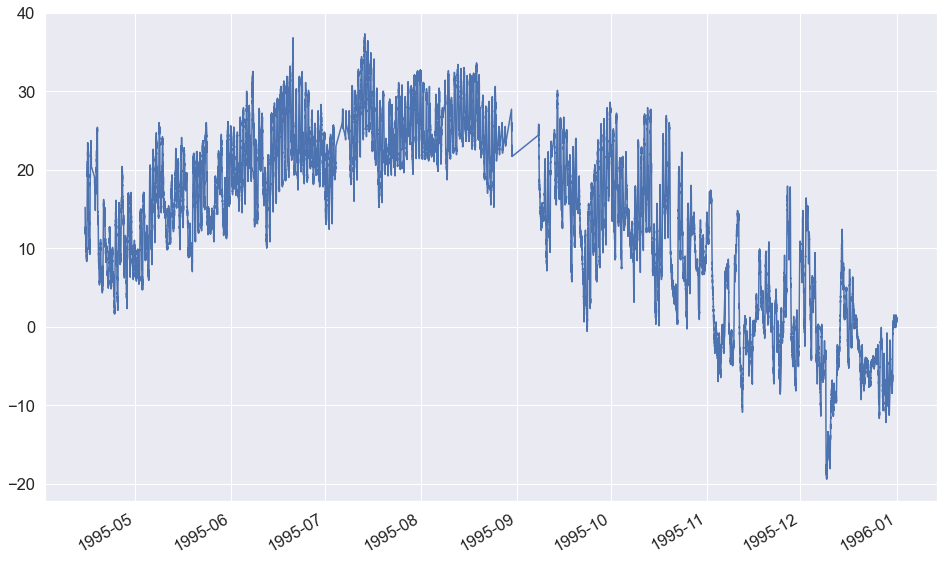

In [10]:
df.temp_air.plot(figsize=(16, 10))

In [11]:
LATITUDE = header['latitude']
LONGITUDE = header['longitude']
ELEVATION = header['elevation']
TIMES = df.index

In [12]:
# get solar position
sp = pvlib.solarposition.get_solarposition(
        TIMES, LATITUDE, LONGITUDE)
solar_zenith = sp.apparent_zenith.values
solar_azimuth = sp.azimuth.values
zenith = sp.zenith.values
ghi = df.ghi.values

In [13]:
# check the calculated zenith from SURFRAD
ze_mbe = 100 * (
    sum(solar_zenith - df.solar_zenith.values)
    / sum(df.solar_zenith.values))
print(f'zenith MBE: {ze_mbe}%')

zenith MBE: 0.00339097060854242%


In [14]:
# get irrad components
irrad = pvlib.irradiance.erbs(ghi, zenith, TIMES)
dni = irrad.dni.values
dhi = irrad.dhi.values
kt = irrad.kt.values  # clearness index

# calculate irradiance inputs
dni_extra = pvlib.irradiance.get_extra_radiation(TIMES).values

In [19]:
# estimate air temp
year_start = weather_years[0].parts[-1]
TL = pvlib.clearsky.lookup_linke_turbidity(TIMES, LATITUDE, LONGITUDE)
AM = pvlib.atmosphere.get_relative_airmass(solar_zenith)
PRESS = pvlib.atmosphere.alt2pres(ELEVATION)
AMA = pvlib.atmosphere.get_absolute_airmass(AM, PRESS)
CS = pvlib.clearsky.ineichen(solar_zenith, AMA, TL, ELEVATION, dni_extra)

# estimate air temp
est_air_temp, temp_adj, ghi_ratio, daily_delta_temp, cs_temp_air = \
    estimate_air_temp(year_start, df,LATITUDE, LONGITUDE, CS)
temp_air = est_air_temp['Adjusted Temp (C)'].loc[TIMES].values

In [20]:
ghi_ratio.describe()

count    356.000000
mean       0.698930
std        0.315906
min        0.000000
25%        0.432454
50%        0.802721
75%        0.962886
max        1.500000
Name: ghi_ratio, dtype: float64

In [21]:
est_air_temp.head()

,Clear Sky Temperature (C),ghi_ratio,temp_adj,Adjusted Temp (C)
1995-01-01 00:00:00+00:00,-0.568291,0.244713,-3.472208,-4.040499
1995-01-01 00:01:00+00:00,-0.573660,0.244930,-3.471214,-4.044874
1995-01-01 00:02:00+00:00,-0.579066,0.245147,-3.470220,-4.049286
1995-01-01 00:03:00+00:00,-0.584509,0.245364,-3.469226,-4.053735
1995-01-01 00:04:00+00:00,-0.589990,0.245581,-3.468232,-4.058222


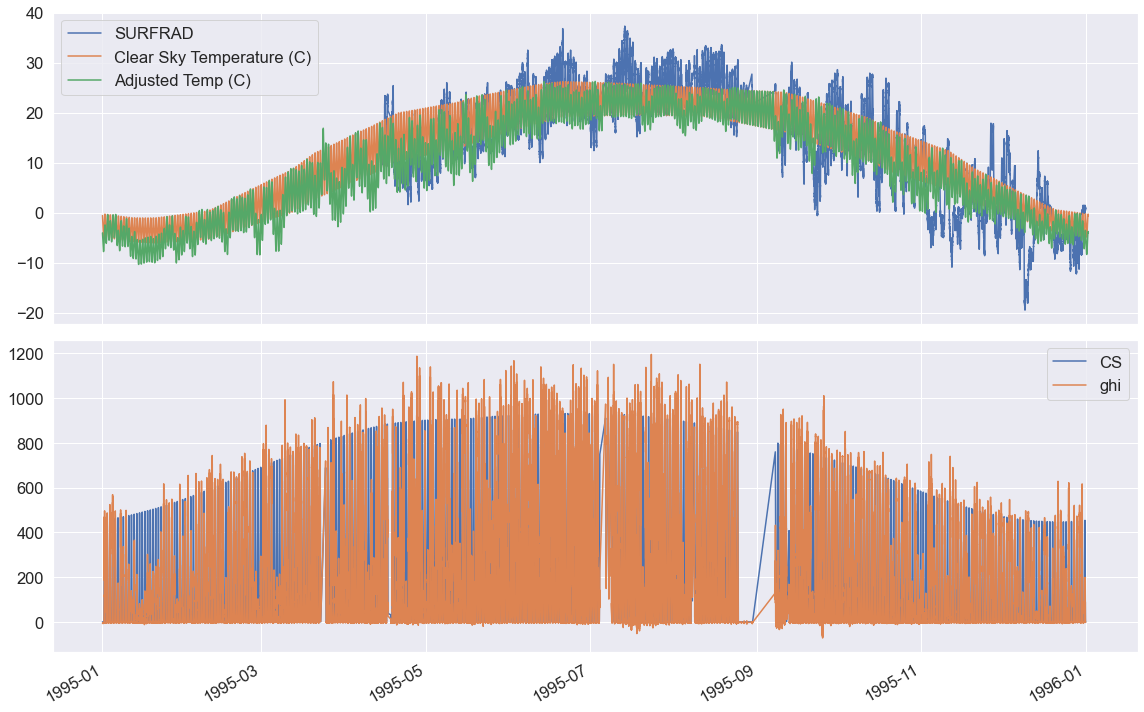

In [23]:
f, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 10))
df.temp_air.plot(ax=ax[0], label='SURFRAD')
est_air_temp[['Clear Sky Temperature (C)', 'Adjusted Temp (C)']].plot(ax=ax[0])
ax[0].legend()
CS.ghi.plot(ax=ax[1], label='CS')
df.ghi.plot(ax=ax[1])
ax[1].legend()
plt.tight_layout()

## Load SURFRAD daily weather data
Each day is in a separate file. We already read this in using pvlib

In [ ]:
len(df)

In [ ]:
ws.columns

In [ ]:
ws.index

## Sanity check
Look at a few timestamps around solar noon and display only a handful of columns:
* direct normal irradiance (DNI): `'Pyrh1_Wm2_Avg'`
* global horizontal irradiance (GHI): `'Pyra1_Wm2_Avg'`
* diffuse horizontal irradiance (DHI): `'Pyrad1_Wm2_Avg'`
* solar zenith: `'SolarZenith_deg_Avg'`
* wind speed: `'WindSpeedAve_ms'`
* air temperature: `'AirTemp_C_Avg'`

In [ ]:
# view a few timestamps to sanity check (E. Tufte, ...)
data_cols = ['Pyrh1_Wm2_Avg', 'Pyra1_Wm2_Avg', 'Pyrad1_Wm2_Avg', 'SolarZenith_deg_Avg', 'WindSpeedAve_ms', 'AirTemp_C_Avg']
ws['2017-01-01 12:09':'2017-01-01 12:18'][data_cols]  # <-- XXX: pick dates for each month

## Data quality
Do some basic quality checking:
1. no irradiance should be negative
2. the DHI has to be the same as
    $$GHI - DNI \cos \left( \theta \right)$$

Then plot a sample day and take a look:

In [ ]:
dni = np.maximum(0, ws['Pyrh1_Wm2_Avg'])
ghi = np.maximum(0, ws['Pyra1_Wm2_Avg'])
dif = np.maximum(0, ws['Pyrad1_Wm2_Avg'])
zerad = np.radians(ws['SolarZenith_deg_Avg'])
dhi = pd.Series(np.maximum(0, ghi - dni*np.cos(zerad)), name='DHI')
irrad = pd.concat([dni, ghi, dif, dhi], axis=1)

In [ ]:
LOGGER.setLevel(logging.ERROR)
irrad['2017-01-07 06:00':'2017-01-07 18:00'].plot()  # <-- XXX: pick dates for each month

In [ ]:
irrad['2017-07-07 06:00':'2017-07-07 18:00'].plot()

## assembling weather file
To model the output we need the following columns:
1. datetime as ISO8601 but no nanoseconds or timezone
2. GHI
2. DHI (_AKA_: DIF)
3. Temp
4. WS

In [ ]:
# get other parameters needed for modeling like windspeed and air temp
wspd = ws['WindSpeedAve_ms']
tair = ws['AirTemp_C_Avg']

In [ ]:
weather = pd.concat([ghi, dhi, tair, wspd], axis=1)
weather.index.name = 'datetime'
weather.columns = ['GHI', 'DIF', 'Temp', 'WS']
weather.head()

In [ ]:
weather.loc['2017-01-01 08:22']  # <-- XXX: pick dates for each month

## Simulate 5-minute sampled satellite data
Choose instantaneous records every five minutes. Choose approximately the middle of the 5-minute sampling interval. Since these are 1-minute timestamps already, the closest to the middle is either the 2nd or 3rd minute.

In [ ]:
every5min = list(range(2, 60, 5))
every5min

### Shift index
We need the timestamp to be at the start of the sampling interval

In [ ]:
weather5inst = weather[weather.index.minute.isin(every5min)].shift(freq='-2min')
weather5inst60min = weather5inst.resample('H').mean()
weather5inst60min['2017-01-07 06:00':'2017-01-07 18:00']

## Ditto for every 15-minutes
Repeat for 15 minute intervals. Same dilemma, the closest record to the middle of the interval is either the 7th or 8th minute.

In [ ]:
every15min = list(range(7, 60, 15))
every15min

In [ ]:
weather15inst = weather[weather.index.minute.isin(every15min)].shift(freq='-7min')
weather15inst60min = weather15inst.resample('H').mean()
weather15inst60min['2017-01-07 06:00':'2017-01-07 18:00']

## Ditto 60-minutes

In [ ]:
weather30inst = weather[weather.index.minute.isin([15, 45])].shift(freq='-15min')
weather30inst60min = weather30inst.resample('H').mean()
weather30inst60min['2017-01-07 06:00':'2017-01-07 18:00']

# Visual Comparison of different sampling intervals
How do these look compared to each other? Are they shifted correctly? Are they on the same order? Do they capture the variability?

In [ ]:
ax = weather['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].plot()
weather5inst['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].shift(freq='2min').plot(ax=ax, marker='o', ms=5)
weather15inst['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].shift(freq='7min').plot(ax=ax, marker='o', ms=10)
weather30inst['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].shift(freq='15min').plot(ax=ax, marker='o', ms=15)
plt.legend(['1-inst', '5-inst', '15-inst', '30-inst'])

In [ ]:
ax = weather['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].plot()
weather5inst['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].shift(freq='2min').plot(ax=ax, marker='o', ms=5)
weather15inst['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].shift(freq='7min').plot(ax=ax, marker='o', ms=10)
weather30inst['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].shift(freq='15min').plot(ax=ax, marker='o', ms=15)
plt.legend(['1-inst', '5-inst', '15-inst', '30-inst'])
plt.title('Instantaneous measurements taken at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

## Hourly averages from instantaneously sampled

In [ ]:
ax = weather.resample('H').mean().shift(freq='30min')['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].plot(marker='o')
weather5inst60min.shift(freq='30min')['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].plot(ax=ax, marker='o')
weather15inst60min.shift(freq='30min')['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].plot(ax=ax, marker='o')
weather30inst60min.shift(freq='30min')['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_60-min', '5-inst_60-min', '15-inst_60-min', '30-inst_60-min'])

In [ ]:
ax = weather.resample('H').mean().shift(freq='30min')['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].plot(marker='o')
weather5inst60min.shift(freq='30min')['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].plot(ax=ax, marker='o')
weather15inst60min.shift(freq='30min')['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].plot(ax=ax, marker='o')
weather30inst60min.shift(freq='30min')['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_60-min', '5-inst_60-min', '15-inst_60-min', '30-inst_60-min'])
plt.title('Simulated satellite data averaged hourly from instantaneous measurements at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

In [ ]:
weather.resample('H').mean()['2017-01-07 06:00':'2017-01-07 18:00']

## Compare 15-minute time averaged to 15-minute instantaneous
How do shorter sampling intervals compare to time averaged values? Starting with 1-minute data, average every 15-minutes and compare to picking a single instantaneous record every 15 minutes, starting at the 7th minute.

In [ ]:
ax = weather.resample('15T').mean().shift(freq='450s')['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].plot(marker='o')
weather15inst['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].shift(freq='7min').plot(ax=ax, marker='o')
plt.legend(['1-inst_15-min', '15-inst'])

In [ ]:
ax = weather.resample('15T').mean().shift(freq='450s')['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].plot(marker='o')
weather15inst['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].shift(freq='7min').plot(ax=ax, marker='o')
plt.legend(['1-inst_15-min', '15-inst'])

In [ ]:
weather.resample('15T').mean()['2017-01-07 10:30':'2017-01-07 13:30']

# save output
Save the files we need to run SolarFarmer

In [ ]:
month = 'allmonths'
output_dir = pathlib.Path(f'instantaneous_{month}')
output_dir.mkdir(exist_ok=False)  # <-- January is already done

In [ ]:
weather5inst.dropna().to_csv(output_dir / f'NIST_{month}-2017_5-inst.tab', sep='\t')
weather5inst60min.dropna().to_csv(output_dir / f'NIST_{month}-2017_5-inst_60-min.tab', sep='\t')

In [ ]:
weather15inst.dropna().to_csv(output_dir / f'NIST_{month}-2017_15-inst.tab', sep='\t')
weather15inst60min.dropna().to_csv(output_dir / f'NIST_{month}-2017_15-inst_60-min.tab', sep='\t')

In [ ]:
weather30inst.dropna().to_csv(output_dir / f'NIST_{month}-2017_30-inst.tab', sep='\t')
weather30inst60min.dropna().to_csv(output_dir / f'NIST_{month}-2017_30-inst_60-min.tab', sep='\t')

In [ ]:
weather60inst = weather[weather.index.minute.isin([30])].shift(freq='-30min')
weather60inst['2017-01-07 06:00':'2017-01-07 18:00']

In [ ]:
weather60inst.dropna().to_csv(output_dir / f'NIST_{month}-2017_60-inst.tab', sep='\t')

# Time Averaged
This is the original clipping error problem.

In [ ]:
weather.dropna().to_csv(output_dir / f'NIST_{month}-2017_1-min.tab', sep='\t')
weather.resample('5T').mean().dropna().to_csv(output_dir / f'NIST_{month}-2017_5-min.tab', sep='\t')
weather.resample('15T').mean().dropna().to_csv(output_dir / f'NIST_{month}-2017_15-min.tab', sep='\t')
weather.dropna().resample('30T').mean().dropna().to_csv(output_dir / f'NIST_{month}-2017_30-min.tab', sep='\t')
weather.resample('H').mean().dropna().to_csv(output_dir / f'NIST_{month}-2017_60-min.tab', sep='\t')